In [3]:
import glob
import os
from natsort import natsorted

data_dir = '../data_nii'

train_images = natsorted(glob.glob(os.path.join(data_dir, "images", "*.nii.gz")))
train_masks = natsorted(glob.glob(os.path.join(data_dir, "masks", "*.nii.gz")))

print(train_images)
print(train_masks)

data_dicts = [{
            "image": image_name,
            "mask": mask_name} for image_name, mask_name in zip(train_images, train_masks)]

['../data_nii\\images\\image_0.nii.gz', '../data_nii\\images\\image_1.nii.gz', '../data_nii\\images\\image_2.nii.gz', '../data_nii\\images\\image_3.nii.gz', '../data_nii\\images\\image_4.nii.gz', '../data_nii\\images\\image_5.nii.gz', '../data_nii\\images\\image_6.nii.gz', '../data_nii\\images\\image_7.nii.gz', '../data_nii\\images\\image_8.nii.gz', '../data_nii\\images\\image_9.nii.gz', '../data_nii\\images\\image_10.nii.gz', '../data_nii\\images\\image_11.nii.gz', '../data_nii\\images\\image_12.nii.gz', '../data_nii\\images\\image_13.nii.gz', '../data_nii\\images\\image_14.nii.gz', '../data_nii\\images\\image_15.nii.gz', '../data_nii\\images\\image_16.nii.gz', '../data_nii\\images\\image_17.nii.gz', '../data_nii\\images\\image_18.nii.gz', '../data_nii\\images\\image_19.nii.gz', '../data_nii\\images\\image_21.nii.gz', '../data_nii\\images\\image_22.nii.gz', '../data_nii\\images\\image_23.nii.gz', '../data_nii\\images\\image_24.nii.gz', '../data_nii\\images\\image_25.nii.gz', '../data_

In [9]:
root_dir = '../augmented_data/'

In [5]:
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    Invertd,
    RandFlipd,
    RandRotate90d,
    RandShiftIntensityd,
    RandGaussianNoised,
    RandAffined,
    ToTensord,
# Add this import
)


train_transforms = Compose(
    [
        LoadImaged(keys=["image", "mask"]),
        EnsureChannelFirstd(keys=["image", "mask"]),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "mask"], source_key="image"),
        Orientationd(keys=["image", "mask"], axcodes="RAS"),
        Spacingd(keys=["image", "mask"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        RandCropByPosNegLabeld(
            keys=["image", "mask"],
            label_key="mask",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        # user can also add other random transforms
        # RandAffined(
        #     keys=['image', 'mask'],
        #     mode=('bilinear', 'nearest'),
        #     prob=1.0, spatial_size=(96, 96, 96),
        #     rotate_range=(0, 0, np.pi/15),
        #     scale_range=(0.1, 0.1, 0.1)),
    ]
)


val_transforms = Compose(
    [
        LoadImaged(keys=["image", "mask"]),
        EnsureChannelFirstd(keys=["image", "mask"]),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "mask"], source_key="image"),
        Orientationd(keys=["image", "mask"], axcodes="RAS"),
        Spacingd(keys=["image", "mask"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
    ]
)

augment = Compose([
    LoadImaged(keys=["image", "mask"]),           # Load image and label
    EnsureChannelFirstd(keys=["image", "mask"]),
    ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),                 # Normalize intensity
    RandFlipd(keys=["image", "mask"], prob=0.5, spatial_axis=0),  # Random flip along x-axis
    RandFlipd(keys=["image", "mask"], prob=0.5, spatial_axis=1),  # Random flip along y-axis
    RandRotate90d(keys=["image", "mask"], prob=0.5, max_k=3),     # Random 90-degree rotation
    RandShiftIntensityd(keys="image", offsets=0.1, prob=0.5),      # Random intensity shift
    RandGaussianNoised(keys="image", prob=0.3, mean=0.0, std=0.01), # Add Gaussian noise
    RandAffined(
        keys=["image", "mask"],
        mode=("bilinear", "nearest"),
        prob=0.5,
        rotate_range=(0.1, 0.1, 0.1),     # Random small rotations
        scale_range=(0.1, 0.1, 0.1)       # Random scaling
    ),
    ToTensord(keys=["image", "mask"])             # Convert to tensor
])

c:\ProgramData\anaconda3\Lib\site-packages\monai\utils\deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


In [10]:
from torch.utils.data import DataLoader
import nibabel as nib
import numpy as np
from monai.data import Dataset

# Assuming augment is your transform and data_dicts is your list of data dictionaries
dataset = Dataset(data=data_dicts, transform=augment)
data_loader = DataLoader(dataset, batch_size=1)

# Function to save NIfTI images
def save_nifti_image(image, path):
    # Assuming `image` is a torch tensor, convert it to a Numpy array and save as NIfTI
    image_numpy = image.squeeze().cpu().numpy()  # remove batch and channel dimensions
    nii_image = nib.Nifti1Image(image_numpy, affine=np.eye(4))  # Use identity matrix for affine
    nib.save(nii_image, path)

# Iterate over the data_loader
for i, batch in enumerate(data_loader):
    image = batch['image']
    mask = batch['mask']

    # Define file paths for saving
    image_path = f'augmented_image{i}.nii'
    mask_path = f'augmented_mask{i}.nii'

    # Save the augmented images and masks
    save_nifti_image(image, root_dir + image_path)
    save_nifti_image(mask, root_dir + mask_path)


In [12]:
import os
import nibabel as nib


augmented_data_dir = '../augmented_data'  # Make sure this path is correct

for image_file in os.listdir(augmented_data_dir):
    # Build the full path to the image file
    image_path = os.path.join(augmented_data_dir, image_file)
    
    # Ensure the file is a NIfTI image
    if image_file.endswith(".nii") or image_file.endswith(".nii.gz"):
        img = nib.load(image_path)  # Load the NIfTI image

        # Get image data as a NumPy array
        image_data = img.get_fdata()

        # Get shape (dimensions)
        print(f"Image: {image_file}")
        print("Image shape:", image_data.shape)  # Shape in (Height, Width, Depth)

        # Get voxel resolution (spacing)
        voxel_spacing = img.header.get_zooms()
        print("Voxel spacing:", voxel_spacing)  # Voxel size in mm (e.g., (1.0, 1.0, 2.0))
        print("-" * 30)  # Separator for clarity

    else:
        print(f"Skipping non-NIfTI file: {image_file}")


Image: augmented_image0.nii
Image shape: (1024, 1024, 179)
Voxel spacing: (1.0, 1.0, 1.0)
------------------------------
Image: augmented_image1.nii
Image shape: (1024, 1024, 105)
Voxel spacing: (1.0, 1.0, 1.0)
------------------------------
Image: augmented_image10.nii
Image shape: (1024, 1024, 150)
Voxel spacing: (1.0, 1.0, 1.0)
------------------------------
Image: augmented_image11.nii
Image shape: (512, 512, 158)
Voxel spacing: (1.0, 1.0, 1.0)
------------------------------
Image: augmented_image12.nii
Image shape: (512, 512, 171)
Voxel spacing: (1.0, 1.0, 1.0)
------------------------------
Image: augmented_image13.nii
Image shape: (512, 512, 162)
Voxel spacing: (1.0, 1.0, 1.0)
------------------------------
Image: augmented_image14.nii
Image shape: (512, 512, 167)
Voxel spacing: (1.0, 1.0, 1.0)
------------------------------
Image: augmented_image15.nii
Image shape: (512, 512, 149)
Voxel spacing: (1.0, 1.0, 1.0)
------------------------------
Image: augmented_image16.nii
Image s

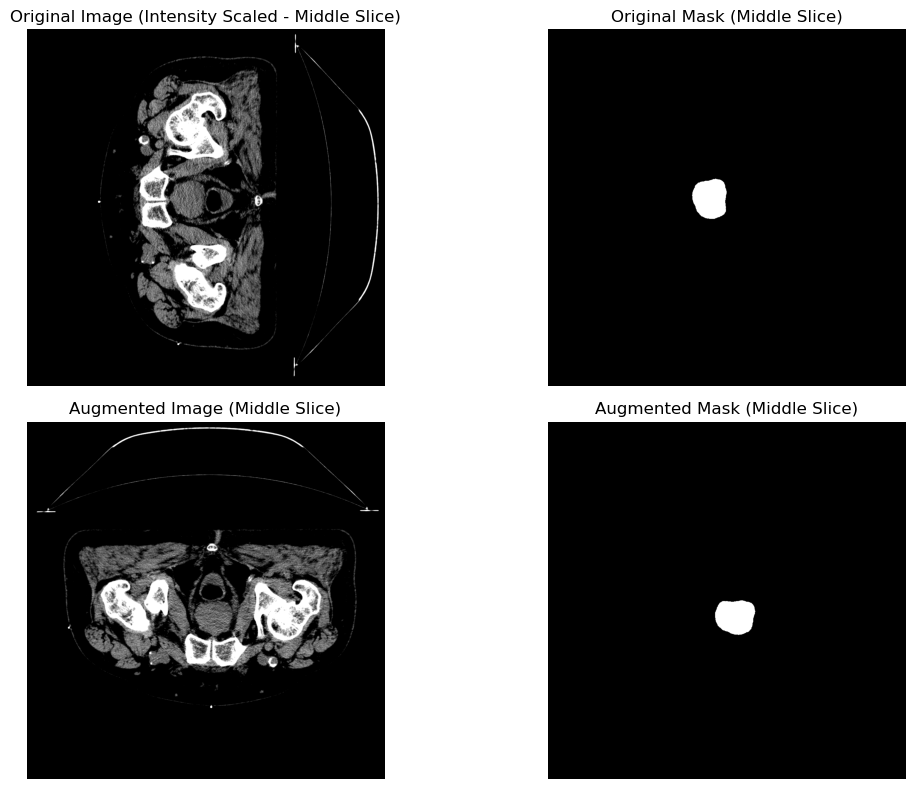

In [7]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from monai.transforms import Compose, LoadImaged, EnsureChannelFirstd, ScaleIntensityRanged, \
                             RandFlipd, RandRotate90d, RandShiftIntensityd, RandGaussianNoised, \
                             RandAffined, ToTensord
from monai.data import Dataset, DataLoader

# Define the augmentation pipeline
augment = Compose([
    LoadImaged(keys=["image", "mask"]),
    EnsureChannelFirstd(keys=["image", "mask"]),
    ScaleIntensityRanged(
        keys=["image"],
        a_min=-57, a_max=164,  # Hounsfield Unit range
        b_min=0.0, b_max=1.0,
        clip=True
    ),
    RandFlipd(keys=["image", "mask"], prob=0.5, spatial_axis=0),  # Random horizontal flip
    RandRotate90d(keys=["image", "mask"], prob=0.5, max_k=3),     # Random 90-degree rotation
    RandShiftIntensityd(keys="image", offsets=0.1, prob=0.5),     # Intensity shift
    RandGaussianNoised(keys="image", prob=0.3, mean=0.0, std=0.01), # Add Gaussian noise
    RandAffined(
        keys=["image", "mask"],
        mode=("bilinear", "nearest"),
        prob=0.5,
        rotate_range=(0.1, 0.1, 0.1),
        scale_range=(0.1, 0.1, 0.1)
    ),
    ToTensord(keys=["image", "mask"])
])

# Define the intensity scaling transform for the original image
scale_original_image = Compose([
    LoadImaged(keys=["image", "mask"]),
    EnsureChannelFirstd(keys=["image", "mask"]),
    ScaleIntensityRanged(
        keys=["image"],
        a_min=-57, a_max=164,  # Hounsfield Unit range
        b_min=0.0, b_max=1.0,
        clip=True
    ),
    ToTensord(keys=["image", "mask"])
])

# Load a single CT image and mask
ct_image_path = "../data_nii/images/image_0.nii.gz"  # Replace with your CT image path
mask_path = "../data_nii/masks/mask0Prostate.nii.gz" # Replace with your mask path

data_dict = {"image": ct_image_path, "mask": mask_path}

# Datasets for augmented and scaled original images
scaled_dataset = Dataset(data=[data_dict], transform=scale_original_image)  # Scaled original
augmented_dataset = Dataset(data=[data_dict], transform=augment)  # Augmented

# Dataloaders
scaled_loader = DataLoader(scaled_dataset, batch_size=1)
augmented_loader = DataLoader(augmented_dataset, batch_size=1)

# Function to visualize the original (scaled) and augmented images
def visualize_scaled_and_augmented(scaled_loader, augmented_loader):
    # Load scaled original image and mask
    scaled_batch = next(iter(scaled_loader))
    scaled_image = scaled_batch["image"][0, 0].numpy()
    scaled_mask = scaled_batch["mask"][0, 0].numpy()

    # Load augmented image and mask
    augmented_batch = next(iter(augmented_loader))
    augmented_image = augmented_batch["image"][0, 0].numpy()
    augmented_mask = augmented_batch["mask"][0, 0].numpy()

    # Plot the scaled original and augmented images
    fig, ax = plt.subplots(2, 2, figsize=(12, 8))

    # Scaled original image and mask
    ax[0, 0].imshow(scaled_image[:, :, scaled_image.shape[2] // 2], cmap="gray")
    ax[0, 0].set_title("Original Image (Intensity Scaled - Middle Slice)")
    ax[0, 0].axis("off")

    ax[0, 1].imshow(scaled_mask[:, :, scaled_mask.shape[2] // 2], cmap="gray")
    ax[0, 1].set_title("Original Mask (Middle Slice)")
    ax[0, 1].axis("off")

    # Augmented image and mask
    ax[1, 0].imshow(augmented_image[:, :, augmented_image.shape[2] // 2], cmap="gray")
    ax[1, 0].set_title("Augmented Image (Middle Slice)")
    ax[1, 0].axis("off")

    ax[1, 1].imshow(augmented_mask[:, :, augmented_mask.shape[2] // 2], cmap="gray")
    ax[1, 1].set_title("Augmented Mask (Middle Slice)")
    ax[1, 1].axis("off")

    plt.tight_layout()
    plt.show()

# Visualize the scaled original and augmented images
visualize_scaled_and_augmented(scaled_loader, augmented_loader)


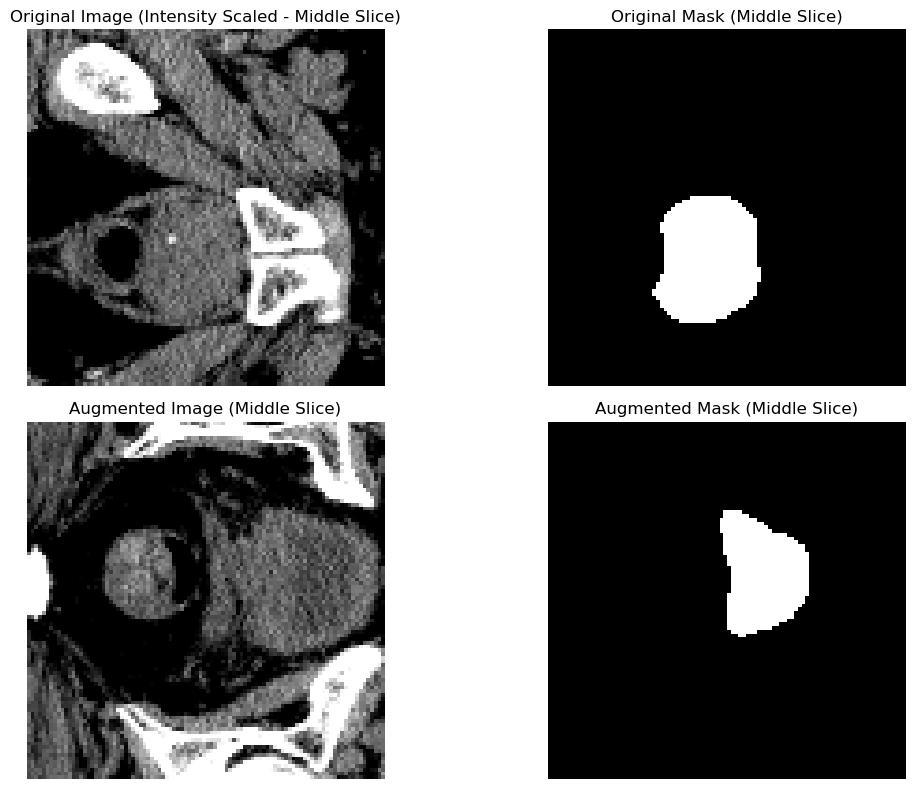

In [ ]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from monai.transforms import Compose, LoadImaged, EnsureChannelFirstd, ScaleIntensityRanged, \
                             RandFlipd, RandRotate90d, RandShiftIntensityd, RandGaussianNoised, \
                             RandAffined, ToTensord
from monai.data import Dataset, DataLoader

# Define the augmentation pipeline
augment = Compose([
    LoadImaged(keys=["image", "mask"]),
    EnsureChannelFirstd(keys=["image", "mask"]),
    ScaleIntensityRanged(
        keys=["image"],
        a_min=-57, a_max=164,  # Hounsfield Unit range
        b_min=0.0, b_max=1.0,
        clip=True
    ),
    RandFlipd(keys=["image", "mask"], prob=0.5, spatial_axis=0),  # Random horizontal flip
    RandRotate90d(keys=["image", "mask"], prob=0.5, max_k=3),     # Random 90-degree rotation
    RandShiftIntensityd(keys="image", offsets=0.1, prob=0.5),     # Intensity shift
    RandGaussianNoised(keys="image", prob=0.3, mean=0.0, std=0.01), # Add Gaussian noise
    RandAffined(
        keys=["image", "mask"],
        mode=("bilinear", "nearest"),
        prob=0.5,
        rotate_range=(0.1, 0.1, 0.1),
        scale_range=(0.1, 0.1, 0.1)
    ),
    ToTensord(keys=["image", "mask"])
])


# Load a single CT image and mask
ct_image_path = "../data_nii/images/image_0.nii.gz"  # Replace with your CT image path
mask_path = "../data_nii/masks/mask0Prostate.nii.gz"       # Replace with your mask path

data_dict = {"image": ct_image_path, "mask": mask_path}
dataset = Dataset(data=[data_dict], transform=augment)  # Single image dataset
data_loader = DataLoader(dataset, batch_size=1)

# Function to visualize the original and augmented images
def visualize_one_image(data_loader):
    # Load and augment the single image
    batch = next(iter(data_loader))  # Get the first batch (one image)

    # Original image and mask (before augmentation)
    original_image = nib.load(ct_image_path).get_fdata()
    original_mask = nib.load(mask_path).get_fdata()

    # Augmented image and mask
    augmented_image = batch["image"][0, 0].numpy()  # Convert tensor back to NumPy
    augmented_mask = batch["mask"][0, 0].numpy()

    # Plot the original and augmented images
    fig, ax = plt.subplots(2, 2, figsize=(12, 8))

    ax[0, 0].imshow(original_image[:, :, original_image.shape[2] // 2], cmap="gray")
    ax[0, 0].set_title("Original Image (Middle Slice)")

    ax[0, 1].imshow(original_mask[:, :, original_mask.shape[2] // 2], cmap="gray")
    ax[0, 1].set_title("Original Mask (Middle Slice)")

    ax[1, 0].imshow(augmented_image[:, :, augmented_image.shape[2] // 2], cmap="gray")
    ax[1, 0].set_title("Augmented Image (Middle Slice)")

    ax[1, 1].imshow(augmented_mask[:, :, augmented_mask.shape[2] // 2], cmap="gray")
    ax[1, 1].set_title("Augmented Mask (Middle Slice)")

    plt.tight_layout()
    plt.show()

# Visualize the original and augmented images
visualize_one_image(data_loader)

